In [1]:
import matplotlib.pyplot as plt
import gensim
import numpy as np
import spacy
import glob
import pickle

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel, TfidfModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import os, re, operator, warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# Configuration
DATA_CLEAN      = 'clean_data/'
YEARS_AVAILABLE = list(range(2008,2018))
TOKEN_NO_BELLOW_FREQ   = 15
TOKEN_NO_ABOVE_PERCENT = 0.5

In [3]:
texts_years = []
for year in YEARS_AVAILABLE:
    with (open("{}{}.pickle".format(DATA_CLEAN, year), "rb")) as openfile:
        while True:
            try:
                texts_years.append(pickle.load(openfile))
            except EOFError:
                break

In [4]:
texts = []
for year in texts_years:
    for abstract in year:
        texts.append(abstract)

In [5]:
len(texts)

1866

In [6]:
bigram = gensim.models.Phrases(texts)

In [7]:
texts = [bigram[line] for line in texts]

In [8]:
texts[11][:10]

['property_rights',
 'inventions',
 'lesson',
 'modern',
 'patent',
 'theory',
 'classic',
 'patent',
 'doctrine',
 'modern']

In [9]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(texts)

# Filter out words that occur less than TOKEN_NO_BELLOW_FREQ documents, 
# or more than TOKEN_NO_ABOVE_PERCENT% of the documents.
dictionary.filter_extremes(no_below=TOKEN_NO_BELLOW_FREQ, no_above=TOKEN_NO_ABOVE_PERCENT)

In [10]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(text) for text in texts]

In [11]:
# tfidf_model = TfidfModel(corpus)
# corpus_tfidf = tfidf_model[corpus]

In [12]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 993
Number of documents: 1866


In [13]:
lsimodel = LsiModel(corpus=corpus, num_topics=8, id2word=dictionary)

In [15]:
lsimodel.show_topics(num_topics=8)  # Showing only the top 8 topics

[(0,
  '-0.439*"firm" + -0.200*"market" + -0.197*"contract" + -0.188*"institution" + -0.178*"country" + -0.161*"model" + -0.159*"state" + -0.147*"level" + -0.140*"law" + -0.130*"cost"'),
 (1,
  '-0.799*"firm" + 0.254*"institution" + 0.165*"country" + 0.135*"law" + 0.125*"state" + 0.116*"government" + 0.111*"policy" + 0.096*"system" + 0.091*"development" + 0.076*"case"'),
 (2,
  '0.780*"contract" + -0.273*"institution" + -0.261*"country" + -0.171*"firm" + 0.162*"party" + 0.113*"cost" + 0.100*"agent" + -0.098*"level" + -0.097*"growth" + 0.096*"information"'),
 (3,
  '0.522*"law" + -0.330*"country" + -0.329*"institution" + 0.312*"state" + -0.299*"contract" + 0.187*"court" + 0.187*"property" + 0.176*"judge" + 0.142*"system" + 0.132*"case"'),
 (4,
  '0.476*"market" + -0.403*"institution" + -0.403*"state" + -0.293*"contract" + -0.193*"law" + -0.182*"firm" + 0.169*"policy" + 0.135*"price" + -0.134*"country" + 0.121*"land"'),
 (5,
  '-0.468*"institution" + -0.457*"market" + 0.297*"country" + 0

In [16]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [17]:
hdpmodel.show_topics()

[(0,
  '0.009*contract + 0.006*firm + 0.006*level + 0.005*party + 0.005*market + 0.005*design + 0.004*model + 0.004*analysis + 0.004*cost + 0.004*coordination + 0.004*agent + 0.004*institution + 0.004*issue + 0.004*century + 0.004*reward + 0.004*court + 0.004*activity + 0.004*production + 0.004*state + 0.003*information'),
 (1,
  '0.007*model + 0.007*firm + 0.006*decision + 0.006*division + 0.005*rent + 0.004*investment + 0.004*product + 0.004*analysis + 0.004*program + 0.004*party + 0.004*effect + 0.004*theory + 0.004*education + 0.004*search + 0.004*impact + 0.004*government + 0.004*element + 0.003*corporation + 0.003*participation + 0.003*land'),
 (2,
  '0.010*firm + 0.007*state + 0.005*risk + 0.005*venture + 0.005*growth + 0.005*system + 0.005*difference + 0.005*leadership + 0.005*war + 0.004*mexico + 0.004*transition + 0.004*equity + 0.004*period + 0.004*sector + 0.004*number + 0.004*security + 0.004*impact + 0.004*player + 0.004*law + 0.004*background'),
 (3,
  '0.008*state + 0.0

In [18]:
# ldamodel = LdaModel(corpus=corpus, num_topics=8, id2word=dictionary)
# Set training parameters.
num_topics = 10
chunksize = 100
passes = 20
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

ldamodel = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

In [ ]:
# ldamodel.show_topics()
ldatopics = ldamodel.show_topics(formatted=False)

In [19]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

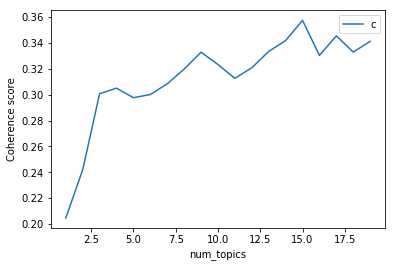

CPU times: user 2min 40s, sys: 2.1 s, total: 2min 42s
Wall time: 2min 44s


In [20]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=texts, limit=20)

In [52]:
# ldamodel = LdaModel(corpus=corpus, num_topics=8, id2word=dictionary)
# Set training parameters.
num_topics = 14
chunksize = 2000
passes = 20
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

ldamodel = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

In [59]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
p = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(p, 'graphs/save_14_LDA_html')

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
10     9.366656        1       1 -0.139712 -0.030902
6      9.159938        1       2 -0.034001  0.082039
12     8.136145        1       3 -0.062068 -0.015922
13     7.760763        1       4  0.029092  0.021566
0      7.565223        1       5  0.061054  0.019034
2      7.485211        1       6  0.094294  0.023792
9      7.264437        1       7  0.081489 -0.094901
8      7.027020        1       8 -0.017506  0.108362
3      6.910999        1       9  0.033971 -0.037047
7      6.139122        1      10  0.097672  0.042095
11     6.045338        1      11 -0.094295  0.057504
1      5.885228        1      12  0.024611 -0.022547
4      5.716510        1      13 -0.061843 -0.086633
5      5.537408        1      14 -0.012759 -0.066441, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
177   Default   740.000000        contract   740.000000  30.0000  30.0000
110   Default  1281.000000            firm  1281.000000  29.0000  29.0000
77    Default   615.000000             law   615.000000  28.0000  28.0000
265   Default   793.000000     institution   793.000000  27.0000  27.0000
540   Default   221.000000            land   221.000000  26.0000  26.0000
87    Default   630.000000           state   630.000000  25.0000  25.0000
27    Default   178.000000      corruption   178.000000  24.0000  24.0000
261   Default   767.000000         country   767.000000  23.0000  23.0000
359   Default   297.000000          growth   297.000000  22.0000  22.0000
512   Default   226.000000      innovation   226.000000  21.0000  21.0000
93    Default   197.000000           trust   197.000000  20.0000  20.0000
144   Default   172.000000          worker   172.000000  19.0000  19.0000
171   Default   396.000000      governance   396.000000  18.0000  18.0000
239   Default   283.000000           price   283.000000  17.0000  17.0000
70    Default   333.000000    organization   333.000000  16.0000  16.0000
444   Default   349.000000      investment   349.000000  15.0000  15.0000
713   Default   209.000000        election   209.000000  14.0000  14.0000
41    Default   762.000000          market   762.000000  13.0000  13.0000
254   Default   279.000000        property   279.000000  12.0000  12.0000
436   Default   211.000000        conflict   211.000000  11.0000  11.0000
143   Default   154.000000           judge   154.000000  10.0000  10.0000
485   Default   289.000000           agent   289.000000   9.0000   9.0000
459   Default   138.000000            bank   138.000000   8.0000   8.0000
68    Default   415.000000           party   415.000000   7.0000   7.0000
36    Default   309.000000        industry   309.000000   6.0000   6.0000
247   Default   146.000000          patent   146.000000   5.0000   5.0000
2     Default   132.000000           voter   132.000000   4.0000   4.0000
88    Default   563.000000      government   563.000000   3.0000   3.0000
307   Default   166.000000       knowledge   166.000000   2.0000   2.0000
574   Default   125.000000         manager   125.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
710   Topic14    19.591871         finance    67.450963   1.6574  -5.4748
854   Topic14     9.304757     rationality    32.328901   1.6482  -6.2194
880   Topic14     6.436563     scholarship    22.723243   1.6323  -6.5879
796   Topic14    13.378971            debt    48.271480   1.6105  -5.8562
142   Topic14     7.623985          lawyer    27.554146   1.6088  -6.4186
49    Topic14    56.434059        economic   216.622198   1.5486  -4.4169
77    Topic14   150.267746             law   615.270179   1.4840  -3.4375
603   Topic14    13.021787          common    48.703341   1.5745  -5.8833
123   Topic14    47.356487           right   248.468302   1.2360  -4.5922
2

In [68]:
# ldamodel = LdaModel(corpus=corpus, num_topics=8, id2word=dictionary)
# Set training parameters.
num_topics = 12
chunksize = 2000
passes = 20
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

ldamodel = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

In [69]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
p = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(p, 'graphs/save_12_LDA_html')

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      12.719236        1       1  0.095557  0.046510
6      10.842296        1       2  0.087540 -0.130705
1      10.779054        1       3 -0.123208  0.018283
4       9.385764        1       4  0.109210 -0.065485
5       8.926940        1       5 -0.047018 -0.019884
10      8.803029        1       6 -0.079241 -0.048998
7       7.606012        1       7 -0.026078 -0.023290
0       6.580016        1       8  0.011392  0.023412
2       6.519742        1       9 -0.079784 -0.005339
9       6.348452        1      10  0.082184  0.113382
8       6.176290        1      11 -0.054676  0.015943
11      5.313169        1      12  0.024123  0.076173, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
110   Default  1298.000000            firm  1298.000000  30.0000  30.0000
177   Default   746.000000        contract   746.000000  29.0000  29.0000
171   Default   394.000000      governance   394.000000  28.0000  28.0000
265   Default   789.000000     institution   789.000000  27.0000  27.0000
540   Default   218.000000            land   218.000000  26.0000  26.0000
139   Default   284.000000           court   284.000000  25.0000  25.0000
261   Default   753.000000         country   753.000000  24.0000  24.0000
77    Default   621.000000             law   621.000000  23.0000  23.0000
143   Default   148.000000           judge   148.000000  22.0000  22.0000
88    Default   558.000000      government   558.000000  21.0000  21.0000
512   Default   225.000000      innovation   225.000000  20.0000  20.0000
254   Default   273.000000        property   273.000000  19.0000  19.0000
52    Default   426.000000     development   426.000000  18.0000  18.0000
436   Default   211.000000        conflict   211.000000  17.0000  17.0000
247   Default   143.000000          patent   143.000000  16.0000  16.0000
123   Default   238.000000           right   238.000000  15.0000  15.0000
272   Default   276.000000      regulation   276.000000  14.0000  14.0000
359   Default   293.000000          growth   293.000000  13.0000  13.0000
93    Default   212.000000           trust   212.000000  12.0000  12.0000
87    Default   650.000000           state   650.000000  11.0000  11.0000
295   Default   439.000000        decision   439.000000  10.0000  10.0000
991   Default    94.000000           crime    94.000000   9.0000   9.0000
765   Default   166.000000       democracy   166.000000   8.0000   8.0000
41    Default   774.000000          market   774.000000   7.0000   7.0000
405   Default   314.000000  property_right   314.000000   6.0000   6.0000
828   Default   114.000000     procurement   114.000000   5.0000   5.0000
189   Default   134.000000       community   134.000000   4.0000   4.0000
199   Default   235.000000         network   235.000000   3.0000   3.0000
144   Default   175.000000          worker   175.000000   2.0000   2.0000
2     Default   129.000000           voter   129.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
838   Topic12    11.706237         cluster    32.291243   1.9203  -5.9485
937   Topic12     9.643412        campaign    27.068219   1.9029  -6.1423
825   Topic12     9.480377         funding    27.588733   1.8668  -6.1594
312   Topic12    13.368546             r&d    39.370629   1.8549  -5.8157
467   Topic12    19.673835   investigation    58.495976   1.8453  -5.4293
558   Topic12     8.649069        survival    26.081987   1.8312  -6.2511
886   Topic12    10.185116      evaluation    32.982653   1.7599  -6.0877
295   Topic12   116.616956        decision   439.876699   1.6074  -3.6497
32    Topic12    91.700871            case   417.378244   1.4195  -3.8901
61    Topic12    21.096194           panel    76.991142   1.6404  -5.3595
448   Topic12    25

In [66]:
# ldamodel = LdaModel(corpus=corpus, num_topics=8, id2word=dictionary)
# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

ldamodel = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

In [67]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
p = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(p, 'graphs/save_10_LDA_html')

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
6      12.805460        1       1 -0.139575  0.003352
5      11.586245        1       2  0.051189 -0.086628
7      11.552240        1       3  0.072711  0.070890
4      11.388704        1       4 -0.091748 -0.056826
8      11.296699        1       5  0.103385 -0.026151
2      10.111886        1       6 -0.010664 -0.014728
3       9.256352        1       7  0.038820 -0.088925
0       8.088220        1       8  0.019646  0.073204
9       7.947279        1       9 -0.007679  0.127947
1       5.966916        1      10 -0.036084 -0.002134, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
110   Default  1244.000000         firm  1244.000000  30.0000  30.0000
77    Default   621.000000          law   621.000000  29.0000  29.0000
177   Default   742.000000     contract   742.000000  28.0000  28.0000
93    Default   201.000000        trust   201.000000  27.0000  27.0000
540   Default   230.000000         land   230.000000  26.0000  26.0000
171   Default   401.000000   governance   401.000000  25.0000  25.0000
27    Default   182.000000   corruption   182.000000  24.0000  24.0000
485   Default   290.000000        agent   290.000000  23.0000  23.0000
261   Default   770.000000      country   770.000000  22.0000  22.0000
88    Default   564.000000   government   564.000000  21.0000  21.0000
713   Default   210.000000     election   210.000000  20.0000  20.0000
265   Default   810.000000  institution   810.000000  19.0000  19.0000
143   Default   155.000000        judge   155.000000  18.0000  18.0000
68    Default   416.000000        party   416.000000  17.0000  17.0000
254   Default   280.000000     property   280.000000  16.0000  16.0000
295   Default   439.000000     decision   439.000000  15.0000  15.0000
765   Default   175.000000    democracy   175.000000  14.0000  14.0000
139   Default   294.000000        court   294.000000  13.0000  13.0000
459   Default   137.000000         bank   137.000000  12.0000  12.0000
41    Default   761.000000       market   761.000000  11.0000  11.0000
247   Default   147.000000       patent   147.000000  10.0000  10.0000
991   Default    97.000000        crime    97.000000   9.0000   9.0000
144   Default   171.000000       worker   171.000000   8.0000   8.0000
455   Default    94.000000         wage    94.000000   7.0000   7.0000
87    Default   653.000000        state   653.000000   6.0000   6.0000
38    Default   351.000000      quality   351.000000   5.0000   5.0000
370   Default   297.000000       sector   297.000000   4.0000   4.0000
2     Default   131.000000        voter   131.000000   3.0000   3.0000
239   Default   292.000000        price   292.000000   2.0000   2.0000
36    Default   308.000000     industry   308.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
716   Topic10    31.921063          job    88.431325   1.8000  -5.0614
932   Topic10     9.452352        ratio    27.629605   1.7463  -6.2784
690   Topic10    12.526882   university    38.789577   1.6887  -5.9968
944   Topic10     9.792075  composition    31.173274   1.6610  -6.2431
593   Topic10    30.454562   reputation    99.955092   1.6305  -5.1084
25    Topic10    15.185825   comparison    49.871809   1.6298  -5.8043
905   Topic10    10.511112     exposure    35.070467   1.6140  -6.1722
230   Topic10    17.726613           eu    59.387132   1.6099  -5.6496
382   Topic10    10.421549     category    35.018552   1.6069  -6.1808
760   Topic10    18.754295     security    63.497022   1.5994  -5.5932
453   Topic10    19.230044  externality    65.635315   1.5913  -5.5682
8     Topic10    58.713343        group   210.247728   1.5433  -4.4520
498   Topic10    22.897947        index    79.043805   1.5800  -5.3936
38    Topic10    79.651734      quality   3

In [70]:
# ldamodel = LdaModel(corpus=corpus, num_topics=8, id2word=dictionary)
# Set training parameters.
num_topics = 8
chunksize = 2000
passes = 20
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

ldamodel = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

In [71]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
p = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(p, 'graphs/save_8_LDA_html')

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      15.816871        1       1 -0.124883 -0.029768
2      15.038875        1       2  0.048286 -0.049016
1      14.294844        1       3  0.129669 -0.067787
4      12.568779        1       4  0.032652  0.075925
5      11.383011        1       5 -0.049573 -0.050800
3      10.723499        1       6 -0.012325  0.099062
6      10.192321        1       7  0.044747  0.045866
7       9.981801        1       8 -0.068572 -0.023482, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
177   Default   745.000000        contract   745.000000  30.0000  30.0000
110   Default  1268.000000            firm  1268.000000  29.0000  29.0000
265   Default   794.000000     institution   794.000000  28.0000  28.0000
261   Default   763.000000         country   763.000000  27.0000  27.0000
254   Default   278.000000        property   278.000000  26.0000  26.0000
77    Default   620.000000             law   620.000000  25.0000  25.0000
540   Default   227.000000            land   227.000000  24.0000  24.0000
139   Default   286.000000           court   286.000000  23.0000  23.0000
405   Default   318.000000  property_right   318.000000  22.0000  22.0000
436   Default   211.000000        conflict   211.000000  21.0000  21.0000
143   Default   151.000000           judge   151.000000  20.0000  20.0000
459   Default   136.000000            bank   136.000000  19.0000  19.0000
144   Default   164.000000          worker   164.000000  18.0000  18.0000
88    Default   569.000000      government   569.000000  17.0000  17.0000
359   Default   300.000000          growth   300.000000  16.0000  16.0000
41    Default   777.000000          market   777.000000  15.0000  15.0000
713   Default   209.000000        election   209.000000  14.0000  14.0000
247   Default   142.000000          patent   142.000000  13.0000  13.0000
622   Default   111.000000        violence   111.000000  12.0000  12.0000
239   Default   298.000000           price   298.000000  11.0000  11.0000
765   Default   172.000000       democracy   172.000000  10.0000  10.0000
7     Default   573.000000          policy   573.000000   9.0000   9.0000
8     Default   205.000000           group   205.000000   8.0000   8.0000
93    Default   214.000000           trust   214.000000   7.0000   7.0000
123   Default   245.000000           right   245.000000   6.0000   6.0000
68    Default   419.000000           party   419.000000   5.0000   5.0000
231   Default   121.000000           water   121.000000   4.0000   4.0000
512   Default   233.000000      innovation   233.000000   3.0000   3.0000
370   Default   302.000000          sector   302.000000   2.0000   2.0000
485   Default   296.000000           agent   296.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
941    Topic8    39.123263      inequality    76.783252   1.6301  -5.3724
846    Topic8    25.134258          empire    49.477148   1.6271  -5.8149
493    Topic8    20.129787             oil    39.769910   1.6235  -6.0370
916    Topic8    23.204976     consumption    45.860125   1.6232  -5.8948
949    Topic8    15.397897          nation    30.631630   1.6166  -6.3049
823    Topic8     9.753700          legacy    19.505419   1.6114  -6.7615
430    Topic8    44.806668         citizen    95.291182   1.5498  -5.2368
2      Topic8    61.642289           voter   134.160818   1.5267  -4.9178
969    Topic8    27.306847      punishment    58.578558   1.5412  -5.7320
723    Topic8    55.577489     equilibrium   155.203150   1.2774  -5.0214
501    Topic8    54.110485          action   182.610481   1.0881  -5.0481
87     Topic8   125.353532           state   661.135000   0.6416  -4.2080
47     Topic8   100.679652          theory   498.274086   0.7052  -4.4272
250    Topic8

In [72]:
# ldamodel = LdaModel(corpus=corpus, num_topics=8, id2word=dictionary)
# Set training parameters.
num_topics = 6
chunksize = 2000
passes = 20
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

ldamodel = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

In [73]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
p = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(p, 'graphs/save_6_LDA_html')

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      26.264182        1       1 -0.070888 -0.053370
1      17.263361        1       2  0.105851  0.052711
4      16.822572        1       3  0.034758 -0.067428
2      14.468282        1       4 -0.043496  0.008106
0      13.000524        1       5  0.040767 -0.024578
5      12.181079        1       6 -0.066991  0.084559, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
177   Default   774.000000      contract   774.000000  30.0000  30.0000
110   Default  1270.000000          firm  1270.000000  29.0000  29.0000
77    Default   627.000000           law   627.000000  28.0000  28.0000
713   Default   200.000000      election   200.000000  27.0000  27.0000
254   Default   280.000000      property   280.000000  26.0000  26.0000
485   Default   298.000000         agent   298.000000  25.0000  25.0000
68    Default   412.000000         party   412.000000  24.0000  24.0000
144   Default   162.000000        worker   162.000000  23.0000  23.0000
512   Default   226.000000    innovation   226.000000  22.0000  22.0000
261   Default   760.000000       country   760.000000  21.0000  21.0000
143   Default   150.000000         judge   150.000000  20.0000  20.0000
2     Default   126.000000         voter   126.000000  19.0000  19.0000
247   Default   144.000000        patent   144.000000  18.0000  18.0000
27    Default   176.000000    corruption   176.000000  17.0000  17.0000
265   Default   803.000000   institution   803.000000  16.0000  16.0000
459   Default   139.000000          bank   139.000000  15.0000  15.0000
93    Default   212.000000         trust   212.000000  14.0000  14.0000
7     Default   574.000000        policy   574.000000  13.0000  13.0000
765   Default   167.000000     democracy   167.000000  12.0000  12.0000
330   Default   325.000000          rule   325.000000  11.0000  11.0000
455   Default    92.000000          wage    92.000000  10.0000  10.0000
307   Default   159.000000     knowledge   159.000000   9.0000   9.0000
139   Default   300.000000         court   300.000000   8.0000   8.0000
41    Default   783.000000        market   783.000000   7.0000   7.0000
137   Default   103.000000         labor   103.000000   6.0000   6.0000
293   Default   106.000000      employee   106.000000   5.0000   5.0000
19    Default   569.000000          cost   569.000000   4.0000   4.0000
6     Default   105.000000    politician   105.000000   3.0000   3.0000
359   Default   300.000000        growth   300.000000   2.0000   2.0000
540   Default   234.000000          land   234.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
689    Topic6    36.685582    employment    66.942126   1.5038  -5.6359
953    Topic6    16.978964     collusion    31.656715   1.4823  -6.4063
158    Topic6    44.021529    litigation    93.696338   1.3499  -5.4536
139    Topic6   107.828230         court   300.059904   1.0818  -4.5577
110    Topic6   326.201691          firm  1270.857234   0.7454  -3.4508
151    Topic6    31.446976  compensation    64.648223   1.3846  -5.7900
32     Topic6   116.143627          case   420.348806   0.8190  -4.4835
161    Topic6    39.097406          task    91.190774   1.2584  -5.5722
14     Topic6   101.069214     incentive   425.874768   0.6669  -4.6225
295    Topic6    98.340072      decision   445.157296   0.5953  -4.6499
283    Topic6    98.982625        effect   496.488423   0.4927  -4.6433
305    Topic6    54.148073          work   170.819844   0.9564  -5.2466
153    Topic6   104.794483         level   641.033614   0.2942  -4.5863
653    Topic6    43.627730  productivity   120.369912   1.0904  -5.4626
136    Topic6    61.520785   enforcement   246.262875   0.7183  -5.1189
450    Topic6    49.322915           tax   163.972100   0.9040  -5.33

In [74]:
# ldamodel = LdaModel(corpus=corpus, num_topics=8, id2word=dictionary)
# Set training parameters.
num_topics = 4
chunksize = 2000
passes = 20
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

ldamodel = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

In [75]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
p = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(p, 'graphs/save_4_LDA_html')

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      28.864712        1       1 -0.081365  0.066880
0      25.114807        1       2  0.080683 -0.002873
2      24.878618        1       3  0.064804  0.012171
3      21.141863        1       4 -0.064123 -0.076179, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
110   Default  1252.000000         firm  1252.000000  30.0000  30.0000
177   Default   757.000000     contract   757.000000  29.0000  29.0000
261   Default   769.000000      country   769.000000  28.0000  28.0000
265   Default   804.000000  institution   804.000000  27.0000  27.0000
713   Default   208.000000     election   208.000000  26.0000  26.0000
485   Default   295.000000        agent   295.000000  25.0000  25.0000
41    Default   773.000000       market   773.000000  24.0000  24.0000
143   Default   154.000000        judge   154.000000  23.0000  23.0000
139   Default   296.000000        court   296.000000  22.0000  22.0000
7     Default   575.000000       policy   575.000000  21.0000  21.0000
512   Default   230.000000   innovation   230.000000  20.0000  20.0000
31    Default   295.000000  transaction   295.000000  19.0000  19.0000
2     Default   130.000000        voter   130.000000  18.0000  18.0000
68    Default   423.000000        party   423.000000  17.0000  17.0000
77    Default   643.000000          law   643.000000  16.0000  16.0000
247   Default   147.000000       patent   147.000000  15.0000  15.0000
359   Default   302.000000       growth   302.000000  14.0000  14.0000
459   Default   140.000000         bank   140.000000  13.0000  13.0000
254   Default   287.000000     property   287.000000  12.0000  12.0000
540   Default   233.000000         land   233.000000  11.0000  11.0000
87    Default   661.000000        state   661.000000  10.0000  10.0000
19    Default   562.000000         cost   562.000000   9.0000   9.0000
991   Default    99.000000        crime    99.000000   8.0000   8.0000
574   Default   124.000000      manager   124.000000   7.0000   7.0000
765   Default   172.000000    democracy   172.000000   6.0000   6.0000
231   Default   121.000000        water   121.000000   5.0000   5.0000
144   Default   172.000000       worker   172.000000   4.0000   4.0000
6     Default   108.000000   politician   108.000000   3.0000   3.0000
88    Default   568.000000   government   568.000000   2.0000   2.0000
36    Default   315.000000     industry   315.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
139    Topic4   211.262059        court   296.962747   1.2134  -4.4366
10     Topic4    46.975080         vote    63.066449   1.2593  -5.9400
430    Topic4    64.296437      citizen    93.660725   1.1777  -5.6262
7      Topic4   311.199256       policy   575.861547   0.9385  -4.0492
648    Topic4    55.319414       leader    81.465626   1.1669  -5.7765
18     Topic4   110.484480   preference   196.191623   0.9797  -5.0848
615    Topic4    45.044795    coalition    63.377414   1.2125  -5.9820
87     Topic4   280.361464        state   661.972836   0.6948  -4.1536
295    Topic4   200.648250     decision   444.472811   0.7586  -4.4881
77     Topic4   252.023123          law   643.228832   0.6169  -4.2601
68     Topic4   184.879696        party   423.222017   0.7257  -4.5700
32     Topic4   173.027932         case   419.832198   0.6675  -4.6362
88     Topic4   211.642340   government   568.814860   0.5653  -4.4348
272    Topic4   121.466959   regulation   282.175306   0.7110  -4.9900
450    Topic4    84.643550          tax   163.300433   0.8968  -5.3512
352    Topic4   118.855043        power   279.410914   0.6991  -5.0118
0      Topic4   219.106928        model   757.830237   0.3130  -4.4001
107    Topic4   101.676468       reform   223.062308   0.7683  -5.1679
330    Topic

In [76]:
# ldamodel = LdaModel(corpus=corpus, num_topics=8, id2word=dictionary)
# Set training parameters.
num_topics = 3
chunksize = 2000
passes = 20
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

ldamodel = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
p = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(p, 'graphs/save_3_LDA_html')

In [77]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      34.650945        1       1 -0.084735 -0.019408
0      33.456208        1       2  0.069573 -0.035632
1      31.892847        1       3  0.015162  0.055040, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
177   Default   743.000000        contract   743.000000  30.0000  30.0000
110   Default  1288.000000            firm  1288.000000  29.0000  29.0000
540   Default   228.000000            land   228.000000  28.0000  28.0000
265   Default   810.000000     institution   810.000000  27.0000  27.0000
765   Default   169.000000       democracy   169.000000  26.0000  26.0000
87    Default   656.000000           state   656.000000  25.0000  25.0000
261   Default   778.000000         country   778.000000  24.0000  24.0000
143   Default   157.000000           judge   157.000000  23.0000  23.0000
459   Default   141.000000            bank   141.000000  22.0000  22.0000
88    Default   563.000000      government   563.000000  21.0000  21.0000
41    Default   780.000000          market   780.000000  20.0000  20.0000
2     Default   133.000000           voter   133.000000  19.0000  19.0000
485   Default   295.000000           agent   295.000000  18.0000  18.0000
52    Default   439.000000     development   439.000000  17.0000  17.0000
828   Default   113.000000     procurement   113.000000  16.0000  16.0000
144   Default   173.000000          worker   173.000000  15.0000  15.0000
247   Default   149.000000          patent   149.000000  14.0000  14.0000
450   Default   161.000000             tax   161.000000  13.0000  13.0000
139   Default   300.000000           court   300.000000  12.0000  12.0000
93    Default   217.000000           trust   217.000000  11.0000  11.0000
991   Default   100.000000           crime   100.000000  10.0000  10.0000
436   Default   218.000000        conflict   218.000000   9.0000   9.0000
31    Default   295.000000     transaction   295.000000   8.0000   8.0000
254   Default   289.000000        property   289.000000   7.0000   7.0000
445   Default   291.000000         capital   291.000000   6.0000   6.0000
444   Default   354.000000      investment   354.000000   5.0000   5.0000
713   Default   216.000000        election   216.000000   4.0000   4.0000
490   Default   135.000000          profit   135.000000   3.0000   3.0000
370   Default   304.000000          sector   304.000000   2.0000   2.0000
272   Default   282.000000      regulation   282.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
272    Topic3   185.026149      regulation   282.539775   0.7195  -4.9803
370    Topic3   191.257078          sector   304.523124   0.6777  -4.9472
87     Topic3   378.210918           state   656.476371   0.5914  -4.2653
52     Topic3   262.584515     development   439.755692   0.6271  -4.6302
199    Topic3   151.574642         network   240.534279   0.6810  -5.1797
444    Topic3   205.596221      investment   354.087691   0.5992  -4.8749
901    Topic3    77.130103          russia   113.494300   0.7565  -5.8553
419    Topic3   162.725175        resource   274.027880   0.6216  -5.1087
265    Topic3   399.271660     institution   810.757933   0.4345  -4.2111
289    Topic3   137.230426        business   225.459163   0.6463  -5.2791
196    Topic3    63.311374  infrastructure    90.639424   0.7840  -6.0527
72     Topic3   155.388062        strategy   272.144787   0.5824  -5.1549
359    Topic3   170.486810          growth   307.497526   0.5530  -5.0621
308    Topic3   151.157532         economy   270.258193   0.5617  -5.1825
261    Topic3   341.932113         country   778.449523   0.3201  -4.3662
41     Topic3   333.623786          market   780.479908   0.2929  -4.3908
88     Topic3   248.608479      government   563.768449   0.3